The link for this lab is [here](https://apmonitor.com/do/index.php/Main/TCLabB). The purpose of this lab is to simulate an energy balance and compare the predictions to deep learning with a multi-layered neural network. The additional feature over the first lab is that the model is extended to two heaters and two temperature sensors.

# Data Gathering   

There are two types of data in use for this lab. THe first is a set of dynamic data recorded from the step response of the system. I could take this, but since I don't have the lab with me, I'll just use the data he posted. 

The second set is a set of steady-state data points used for the NN. They way the network is implemented in this lab is to predict steady-state temperatures given heater values. So the data took 6 hours to get by getting one data point every 20 minutes or so. Im not going to do that part, but this is an interesting approach. The NN predicts steady state values and then we simply fit a generic first order system (i.e. pick a time constant) to generate dynamic predictions with the NN.

# First Principles

I'll use the pdf attachment on the website with the equations of motion and parameter values for the first princples model. THe model includes radiative/convective transfers betwen the environment and the heaters. Conduction is assumed to be negligible. 

*NOTE* The pdf lab handout has different input trajectories and instructions than the website. THis follows the pdf. So the rest of this code will also follow the pdf. I don't have hardware data for the pdf version, so I just won't plot that. 

apm 66.219.236.170_gk_model31 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           14
   Intermediates:            2
   Connections  :            0
   Equations    :            4
   Residuals    :            2
 
 Number of state variables:           2400
 Number of total equations: -         2400
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains

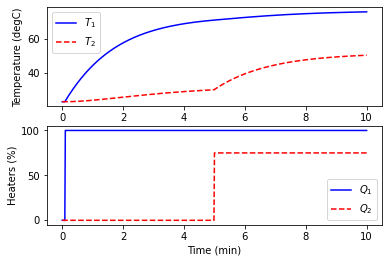

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

#initialize GEKKO model
m = GEKKO()

#model discretized time
n = 60*10+1  # Number of second time points (10min)
m.time = np.linspace(0,n-1,n) # Time vector

# Parameters
# Percent Heater (0-100%)
Q1des = np.zeros(n)
Q1des[6:] = 100

Q2des = np.zeros(n)
Q2des[300:] = 75
Q1 = m.Param(value=Q1des) # Percent Heater (0-100%)
Q2 = m.Param(value=Q2des) # Percent Heater (0-100%)

T0 = m.Param(value=23.0+273.15)     # Initial temperature
Ta = m.Param(value=23.0+273.15)     # K
U =  m.Param(value=10.0)            # W/m^2-K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
alpha1 = m.Param(value=0.01)        # W / % heater
alpha2 = m.Param(value=0.005)      # W / % heater
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzman

# Temperature states as GEKKO variables
T1 = m.Var(value=T0)
T2 = m.Var(value=T0)         

# Between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

m.Equation(T1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(T2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

#simulation mode
m.options.IMODE = 4

#simulation model
m.solve()

#plot results
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(m.time/60.0,np.array(T1.value)-273.15,'b-')
plt.plot(m.time/60.0,np.array(T2.value)-273.15,'r--')
plt.legend([r'$T_1$',r'$T_2$'],loc='best')
plt.ylabel('Temperature (degC)')

plt.subplot(2,1,2)
plt.plot(m.time/60.0,np.array(Q1.value),'b-')
plt.plot(m.time/60.0,np.array(Q2.value),'r--')
plt.legend([r'$Q_1$',r'$Q_2$'],loc='best')
plt.ylabel('Heaters (%)')

plt.xlabel('Time (min)')
plt.show()

## Questions


1. How much effect does Q1 have on T2 starting at t=0.1 min?
 A slight effect. T2 is rising, but not fast.
2. How much effect does Q2 have on T1 starting at t=5 min?
 Basically no effect.
3. How would the response change if you were to slide a coin between the two heat sinks so that there is a
continuous metallic interface between the two heaters? How would you change the model equations?
 I would bet that T2 is effected much more by Q1 and that T1 will rise slower and then increase again at 5 min.
4. Is model error due to incorrect parameters or due to incorrect equations?
 Likely both. Since I don't have data for this case, I'll assume that they are more coupled than we model (by ignoring conduction, for example)

# Neural Network

Ill use the brain module of gekko documented [here](https://gekko.readthedocs.io/en/latest/brain.html) instead of manually doing all the layers. 

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from gekko import GEKKO
from gekko import brain

import time

# -------------------------------------
# import or generate data
# -------------------------------------
filename = 'tclab_ss_data2.csv'
try:
    try:
        data = pd.read_csv(filename)
    except:
        url = 'https://apmonitor.com/do/uploads/Main/tclab_ss_data2.txt'
        data = pd.read_csv(url)
except:
    # generate training data if data file not available
    import tclab
    # Connect to Arduino
    a = tclab.TCLab()
    fid = open(filename,'w')
    fid.write('Heater 1,Heater 2,Temperature 1,Temperature 2\n')
    fid.close()
    # data collection takes 6 hours = 120 pts * 3 minutes each
    npts = 120
    for i in range(npts):
        # set random heater values
        Q1 = np.random.rand()*100
        Q2 = np.random.rand()*100
        a.Q1(Q1)
        a.Q2(Q2)
        print('Heater 1: ' + str(Q1) + ' %')
        print('Heater 2: ' + str(Q2) + ' %')
        # wait 3 minutes
        time.sleep(3*60)
        # record temperature and heater value
        print('Temperature 1: ' + str(a.T1) + ' degC')
        print('Temperature 2: ' + str(a.T2) + ' degC')
        fid = open(filename,'a')
        fid.write(str(Q1)+','+str(Q2)+','+str(a.T1)+','+str(a.T2)+'\n')
        fid.close()
    # close connection to Arduino
    a.close()
    # read data file
    data = pd.read_csv(filename)

# -------------------------------------
# scale data
# -------------------------------------
s = MinMaxScaler(feature_range=(0,1))
sc_train = s.fit_transform(data)

# partition into inputs and outputs
xs = sc_train[:,0:2] # 2 heaters
ys = sc_train[:,2:4] # 2 temperatures

# -------------------------------------
# build neural network
# -------------------------------------
b = brain.Brain()
b.input_layer(2)
b.layer(linear=2)
b.layer(tanh=2)
b.layer(linear=2)
b.output_layer(2)
# print(xs.shape)
b.learn(xs.T,ys.T)


# -------------------------------------
# generate dynamic predictions with b
# -------------------------------------

# step tests
Q1des = np.zeros(n)
Q1des[6:] = 100

Q2des = np.zeros(n)
Q2des[300:] = 75

# scaled inputs to pass into nn
Q1des_scaled = Q1des * s.scale_[0] + s.min_[0]
Q2des_scaled = Q2des * s.scale_[1] + s.min_[1] 

#get NN predictions
T_pred = b.think([Q1des_scaled, Q2des_scaled])
T1_pred = np.array(T_pred[0])
T2_pred = np.array(T_pred[1])
#all in C


apm 66.219.236.170_gk_model32 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           28
   Intermediates:           16
   Connections  :            0
   Equations    :           18
   Residuals    :            2
 
 Number of state variables:            264
 Number of total equations: -          240
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             24
 
 **********************************************
 Model Parameter Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

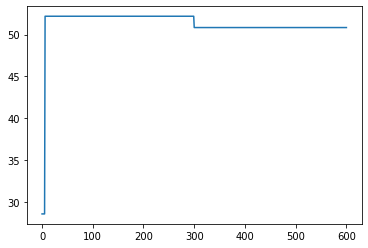

In [63]:
plt.plot((T1_pred-s.min_[2])/s.scale_[2])

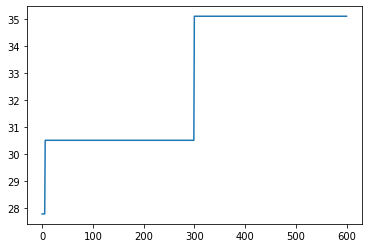

In [62]:
plt.plot((T2_pred-s.min_[3])/s.scale_[3])

In [68]:
tf = 600
m_NN= GEKKO()
m_NN.time = np.linspace(0,tf,tf+1)

# define Temperature output
T0 = 23.0  # ambient temperature

# unscaled scaled steady state ouput
# T1_pred_test = np.zeros(601)
# T1_pred_test[6:]=100
# T2_pred_test = np.zeros(601)
# T2_pred_test[300:] = 40
# T1_ss = m_NN.Param(value=T1_pred_test)
# T2_ss = m_NN.Param(value=T2_pred_test)

T1_ss = m_NN.Param(value=(T1_pred-s.min_[2])/s.scale_[2])
T2_ss = m_NN.Param(value=(T2_pred-s.min_[3])/s.scale_[3])


# dynamic prediction vars
T1_NN = m_NN.Var(value=T0)
T2_NN = m_NN.Var(value=T0)

# time constant
tau = m_NN.Param(value=120) # determine in a later exercise

# additional model equation for dynamics
m_NN.Equation(tau*T1_NN.dt()==-(T1_NN-T0)+(T1_ss-T0))
m_NN.Equation(tau*T2_NN.dt()==-(T2_NN-T0)+(T2_ss-T0))

# solve dynamic simulation
m_NN.options.IMODE=4
m_NN.solve()



apm 66.219.236.170_gk_model40 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            0
   Connections  :            0
   Equations    :            2
   Residuals    :            2
 
 Number of state variables:           2400
 Number of total equations: -         2400
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains

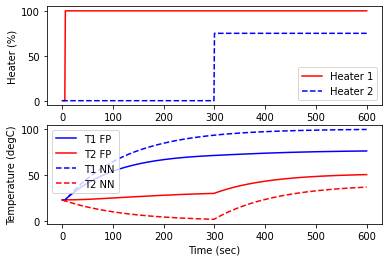

In [69]:
# # generate step test data on Arduino
# # -------------------------------------
# # import or generate data
# # -------------------------------------
# filename = 'tclab_dyn_data2.csv'
# try:
#     try:
#         data = pd.read_csv(filename)
#     except:
#         url = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
#         data = pd.read_csv(url)
# except:
#     # generate training data if data file not available
#     import tclab
#     # Connect to Arduino
#     a = tclab.TCLab()
#     fid = open(filename,'w')
#     fid.write('Time,H1,H2,T1,T2\n')
#     fid.close()
#     # check for cool down
#     i = 0
#     while i<=10:
#         i += 1 # upper limit on wait time
#         T1m = a.T1
#         T2m = a.T2
#         print('T1: ' + str(a.T1) + ' T2: ' + str(a.T2))
#         print('Sleep 30 sec')
#         time.sleep(30)
#         if (a.T1<30 and a.T2<30 and a.T1>=T1m-0.2 and a.T2>=T2m-0.2):
#             break  # continue when conditions met
#         else:
#             print('Not at ambient temperature')
#     # run step test (10 min)
#     for i in range(tf+1):
#         # set heater values
#         a.Q1(Q1des[i])
#         a.Q2(Q2des[i])
#         print('Time: ' + str(i) + \
#               ' H1: ' + str(Q1des[i]) + \
#               ' H2: ' + str(Q2des[i]) + \
#               ' T1: ' + str(a.T1)   + \
#               ' T2: ' + str(a.T2))
#         # wait 1 second
#         time.sleep(1)
#         fid = open(filename,'a')
#         fid.write(str(i)+','+str(Q1des[i])+','+str(Q2des[i])+',' \
#                   +str(a.T1)+','+str(a.T2)+'\n')
#         fid.close()
#     # close connection to Arduino
#     a.close()
#     # read data file
#     data = pd.read_csv(filename)

#don't have data on trajectory, so compare to first principles

# plot prediction and measurement
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,Q1.value,'r-',label='Heater 1')
plt.plot(m.time,Q2.value,'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(m.time,np.array(T1.value)-273.15,'b-', label="T1 FP" )
plt.plot(m.time,np.array(T2.value)-273.15,'r-', label="T2 FP")
plt.plot(m_NN.time,T1_NN.value,'b--',label='T1 NN')
plt.plot(m_NN.time,T2_NN.value,'r--',label='T2 NN')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')

plt.show()

SO NN predictions might be bad. Plus we are wrapping them into 2 non-coupled first order systems. I know we hope the coupling was learned in the T1 and T2 predictions, but it doesn't seem like it makes that much of a difference. The t1 and T2 predictions doe change, but maybe the magnitudes aren't big enough. I tested with random t1 and t2 predictions with huge changes, and it did seem to change more.